In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets

print('python version:', sys.version.split('\n')[0])
for m in [tf, np, pd, mpl]:
    print(m.__name__, 'version:', m.__version__)

python version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
tensorflow version: 2.3.1
numpy version: 1.18.5
pandas version: 1.1.3
matplotlib version: 3.3.2


In [2]:
def preprocess(x, y): # [b,28,28], [b]
    print(x.shape, y.shape)
    x = tf.cast(x, dtype=tf.float32)/255.
    x = tf.reshape(x, [-1, 28*28])
    y = tf.cast(y, dtype=tf.int32)
    y = tf.one_hot(y, depth=10)
    return x,y   

In [10]:
def main():
    lr = 1e-2
    accs, losses = [], []
    
    w1, b1 = tf.Variable(tf.random.normal([784,256], stddev=0.1)), tf.Variable(tf.zeros([256]))
    w2, b2 = tf.Variable(tf.random.normal([256,128], stddev=0.1)), tf.Variable(tf.zeros([128]))
    w3, b3 = tf.Variable(tf.random.normal([128,10], stddev=0.1)), tf.Variable(tf.zeros([10]))
    
    for step, (x,y) in enumerate(train_db):
#         x = tf.reshape(x, [-1, 28*28])
        with tf.GradientTape() as tape:
            h1 = x@w1 + b1
            h1 = tf.nn.relu(h1)
            h2 = h1@w2 + b2
            h2 = tf.nn.relu(h2)
            out = h2@w3 + b3
            
            loss = tf.square(y-out)
            loss = tf.reduce_mean(loss)
            
        grades = tape.gradient(loss, [w1,b1,w2,b2,w3,b3])
        for p,g in zip([w1,b1,w2,b2,w3,b3], grades):
            p.assign_sub(lr*g)
            
        if step%80 == 0:
            # train set
            print(step, 'loss:', float(loss))
            losses.append(float(loss))
            
            # test set
            total, total_correct = 0., 0

            for x, y in test_db:
                
                h1 = x @ w1 + b1
                h1 = tf.nn.relu(h1)
                h2 = h1 @ w2 + b2
                h2 = tf.nn.relu(h2)
                out = h2 @ w3 + b3

                pred = tf.argmax(out, axis=1)
                # convert one_hot y to number y
                y = tf.argmax(y, axis=1)
                # bool type
                correct = tf.equal(pred, y)
                # bool tensor => int tensor => numpy
                total_correct += tf.reduce_sum(tf.cast(correct, dtype=tf.int32)).numpy()
                total += x.shape[0]

            print(step, 'Evaluate Acc:', total_correct/total)
            accs.append(total_correct/total)
            
    plt.figure()
    x = [i*80 for i in range(len(losses))]
    plt.plot(x, losses, color='C0', marker='s', label='Train')
    plt.ylabel('MSE')
    plt.xlabel('Step')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(x, accs, color='C1', marker='s', label='Test')
    plt.ylabel('ACC')
    plt.xlabel('Step')
    plt.legend()
    plt.show()
     

x: (60000, 28, 28) y: (60000,) x test: (10000, 28, 28) y test: [7 2 1 ... 4 5 6]
(None, 28, 28) (None,)
(None, 28, 28) (None,)
train sample: (512, 784) (512, 10)
0 loss: 1.1351094245910645
0 Evaluate Acc: 0.1221
80 loss: 0.18330194056034088
80 Evaluate Acc: 0.2142
160 loss: 0.14945873618125916
160 Evaluate Acc: 0.3036
240 loss: 0.1260005235671997
240 Evaluate Acc: 0.3754
320 loss: 0.11095020920038223
320 Evaluate Acc: 0.4231
400 loss: 0.10475367307662964
400 Evaluate Acc: 0.4643
480 loss: 0.09385822713375092
480 Evaluate Acc: 0.502
560 loss: 0.09577534347772598
560 Evaluate Acc: 0.5326
640 loss: 0.08685914427042007
640 Evaluate Acc: 0.5575
720 loss: 0.0814991146326065
720 Evaluate Acc: 0.582
800 loss: 0.07815351337194443
800 Evaluate Acc: 0.6008
880 loss: 0.07698123157024384
880 Evaluate Acc: 0.6174
960 loss: 0.0741732120513916
960 Evaluate Acc: 0.6323
1040 loss: 0.07265293598175049
1040 Evaluate Acc: 0.6445
1120 loss: 0.07254324853420258
1120 Evaluate Acc: 0.6573
1200 loss: 0.06335801

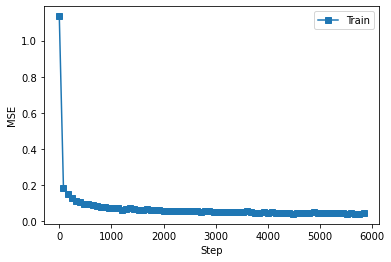

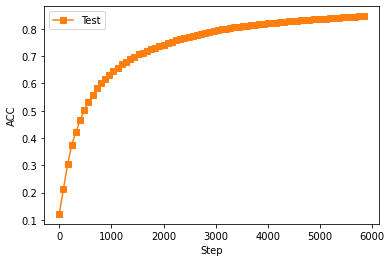

In [12]:
(x,y), (x_test,y_test) = datasets.mnist.load_data()
print('x:', x.shape, 'y:', y.shape, 'x test:', x_test.shape, 'y test:', y_test)

batchsz = 512
train_db = tf.data.Dataset.from_tensor_slices((x,y))
train_db = train_db.shuffle(1000).batch(batchsz).map(preprocess).repeat(50)

test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.shuffle(1000).batch(batchsz).map(preprocess)
x,y = next(iter(train_db))
print('train sample:', x.shape, y.shape)
main()